In [1]:
import io
import time
import gzip

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### some handy functions

In [3]:
def parse_image(file_path):
    if file_path.endswith(".gz"):
        file_handler = gzip
    else:
        file_handler = io
    with file_handler.open(file_path, 'rb') as file_stream:
        parsed_magic_number = int(file_stream.read(4).hex(), 16)
        expected_magic_number = 0x00000803
        if expected_magic_number == parsed_magic_number:
            count = int(file_stream.read(4).hex(), 16)
            row_count = int(file_stream.read(4).hex(), 16)
            col_count = int(file_stream.read(4).hex(), 16)
            return np.frombuffer(file_stream.read(count * row_count * col_count), dtype=np.uint8).reshape(count, row_count, col_count)
        else:
            print("magic number mismatch, expected: {}, got: {}".format(expected_magic_number, parsed_magic_number))


def parse_label(file_path):
    if file_path.endswith(".gz"):
        file_handler = gzip
    else:
        file_handler = io
    with file_handler.open(file_path, 'rb') as file_stream:
        parsed_magic_number = int(file_stream.read(4).hex(), 16)
        expected_magic_number = 0x00000801
        if expected_magic_number == parsed_magic_number:
            count = int(file_stream.read(4).hex(), 16)
            return np.frombuffer(file_stream.read(count), dtype=np.uint8)
        else:
            print("magic number mismatch, expected: {}, got: {}".format(expected_magic_number, parsed_magic_number))


def shuffle(x, y):
    assert x.shape[0] == y.shape[0]
    permute = np.random.permutation(x.shape[0])
    return x[permute], y[permute]


def train(classifier, optimizer, device, x_train, y_train, BATCH_SIZE=1000, EPOCH_SIZE=32):
    x_train = torch.as_tensor(x_train, dtype=torch.float).reshape(-1, 1, 28, 28)
    y_train = torch.as_tensor(y_train, dtype=torch.long)
    classifier.train()
    print("Training")
    for epoch_idx in range(EPOCH_SIZE):
        start_time = time.time()
        x_train, y_train = shuffle(x_train, y_train)
        no_of_batches = x_train.shape[0]//BATCH_SIZE
        for batch_idx in range(no_of_batches):
            batch_start_idx = batch_idx * BATCH_SIZE
            batch_end_idx = batch_start_idx + BATCH_SIZE
            
            device_x_train = x_train[batch_start_idx : batch_end_idx].to(device)
            device_y_train = y_train[batch_start_idx : batch_end_idx].to(device)
            optimizer.zero_grad()
            output = classifier(device_x_train)
            loss = F.cross_entropy(output, device_y_train)
            loss.backward()
            optimizer.step()
        print("{0:2d}: loss = {1:8.4f},  {2:10.4f}s".format(epoch_idx, loss.item(), time.time()-start_time))


def evaluate(classifier, device, x_test, y_test, BATCH_SIZE=1000):
    x_test = torch.as_tensor(x_test, dtype=torch.float).reshape(-1, 1, 28, 28)
    y_test = torch.as_tensor(y_test, dtype=torch.long)
    classifier.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        start_time = time.time()
        x_test, y_test = shuffle(x_test, y_test)
        no_of_batches = x_test.shape[0]//BATCH_SIZE
        for batch_idx in range(no_of_batches):
            batch_start_idx = batch_idx * BATCH_SIZE
            batch_end_idx = batch_start_idx + BATCH_SIZE
            
            device_x_test = x_test[batch_start_idx : batch_end_idx].to(device)
            device_y_test = y_test[batch_start_idx : batch_end_idx].to(device)
            output = classifier(device_x_test)
            total_loss += F.cross_entropy(output, device_y_test, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += prediction.eq(device_y_test.view_as(prediction)).sum().item()
        print("Test: {}/{} = {:.4f}, {:.4f}, {:.4f}s".format(
                correct, batch_end_idx, correct/batch_end_idx, total_loss/batch_end_idx, time.time()-start_time))


def predict(classifier, device, x, num=3):
    x = torch.as_tensor(x, dtype=torch.float).reshape(-1, 1, 28, 28).to(device)
    classifier.eval()
    with torch.no_grad():
        output = classifier(x)
        for _x, _output in zip(x, output):
            show_img(_x[0].to(torch.device("cpu")))
            results = []
            for _, confidence, index in zip(range(num), *torch.sort(_output, descending=True)):
                results.append('{:1d}: {:.3f}'.format(index, confidence))
            print(', '.join(results))


def show_img(x):
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x, cmap=plt.cm.binary)
    plt.show()


def predict_some_results(classifier, device, x, y, num=4):
    for idx in np.random.randint(x.shape[0] - 1, size=num):
        predict(classifier, device, x[idx])
        print(f'expected label: {y[idx]}')


def print_cuda_mem():
    print("CUDA:0 - {:8.6f} GB".format(torch.cuda.memory_allocated()/2**(10*3)))

## MNIST classifier

In [4]:
mnist_x_train = parse_image('../input/mnist-database-of-handwritten-digits/train-images-idx3-ubyte/train-images-idx3-ubyte')
mnist_y_train = parse_label('../input/mnist-database-of-handwritten-digits/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
mnist_x_test  = parse_image('../input/mnist-database-of-handwritten-digits/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
mnist_y_test  = parse_label('../input/mnist-database-of-handwritten-digits/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [5]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(4 * 4 * 64, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [6]:
mnist_classifier = MNISTClassifier().to(device)
mnist_optimizer = optim.Adam(params=mnist_classifier.parameters(), lr=0.01)

In [7]:
train(mnist_classifier, mnist_optimizer, device, mnist_x_train, mnist_y_train, BATCH_SIZE=1000, EPOCH_SIZE=10)

Training
 0: loss =   2.2416,      1.9015s
 1: loss =   2.0302,      0.9152s
 2: loss =   1.7061,      0.9350s
 3: loss =   0.9297,      0.9113s
 4: loss =   0.3971,      0.9094s
 5: loss =   0.3177,      0.9049s
 6: loss =   0.2536,      0.9112s
 7: loss =   0.2422,      0.9042s
 8: loss =   0.1775,      0.9049s
 9: loss =   0.2365,      0.9074s


In [8]:
evaluate(mnist_classifier, device, mnist_x_test, mnist_y_test)

Test: 9282/10000 = 0.9282, 0.2334, 0.0777s


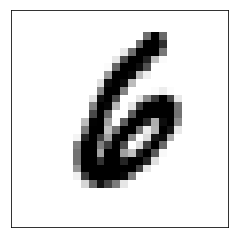

6: -0.001, 0: -7.860, 2: -8.767
expected label: 6


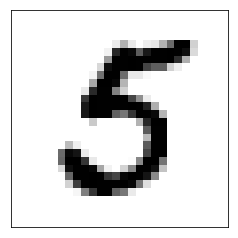

5: -0.083, 6: -2.611, 8: -5.745
expected label: 5


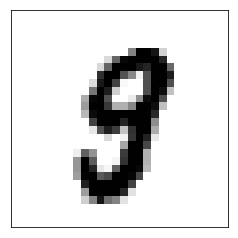

7: -0.954, 9: -1.363, 8: -1.376
expected label: 9


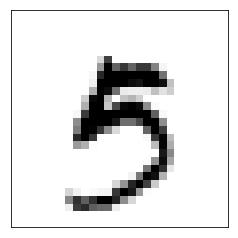

5: -0.221, 8: -2.594, 3: -2.694
expected label: 5


In [9]:
# predict some random digits from test set
# then print top results(label and confidence) with expected labels
predict_some_results(mnist_classifier, device, mnist_x_test, mnist_y_test)

## EMNIST classifier

In [10]:
emnist_x_train = parse_image('../input/emnist-database-of-handwritten-characters/gzip/gzip/emnist-digits-train-images-idx3-ubyte.gz')
emnist_y_train = parse_label('../input/emnist-database-of-handwritten-characters/gzip/gzip/emnist-digits-train-labels-idx1-ubyte.gz')
emnist_x_test  = parse_image('../input/emnist-database-of-handwritten-characters/gzip/gzip/emnist-digits-test-images-idx3-ubyte.gz')
emnist_y_test  = parse_label('../input/emnist-database-of-handwritten-characters/gzip/gzip/emnist-digits-test-labels-idx1-ubyte.gz')

wc_num_lines = !wc --lines '../input/emnist-database-of-handwritten-characters/gzip/gzip/emnist-digits-mapping.txt'
num_classes = int(wc_num_lines[0].split()[0])

In [11]:
# we are transposing each element, because we are reading row-wise(as per mnist) but emnist is stored as col-wise
emnist_x_train = np.transpose(emnist_x_train, (0, 2, 1))
emnist_x_test  = np.transpose(emnist_x_test , (0, 2, 1))

In [12]:
class EMNISTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(4 * 4 * 64, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [13]:
emnist_classifier = EMNISTClassifier(num_classes).to(device)
emnist_optimizer = optim.Adam(params=emnist_classifier.parameters(), lr=0.01)

In [14]:
train(emnist_classifier, emnist_optimizer, device, emnist_x_train, emnist_y_train, BATCH_SIZE=1000, EPOCH_SIZE=10)

Training
 0: loss =   0.2061,      3.6912s
 1: loss =   0.0866,      3.6219s
 2: loss =   0.0801,      3.6211s
 3: loss =   0.0480,      3.6161s
 4: loss =   0.0743,      3.6188s
 5: loss =   0.0573,      3.6049s
 6: loss =   0.0550,      3.6241s
 7: loss =   0.0739,      3.6091s
 8: loss =   0.0877,      3.6186s
 9: loss =   0.0770,      3.6143s


In [15]:
evaluate(emnist_classifier, device, emnist_x_test, emnist_y_test)

Test: 39272/40000 = 0.9818, 0.0724, 0.2623s


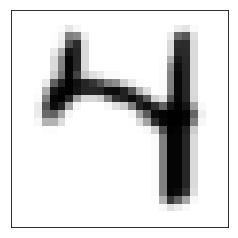

4: -0.006, 7: -5.659, 9: -6.431
expected label: 4


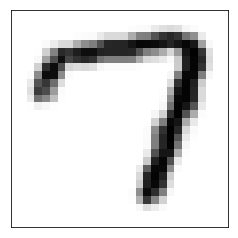

7: -0.000, 2: -9.629, 9: -12.426
expected label: 7


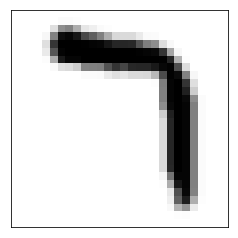

7: 0.000, 2: -14.186, 9: -17.374
expected label: 7


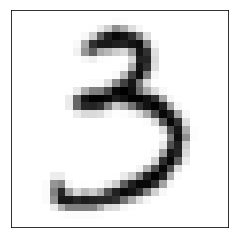

3: 0.000, 5: -14.184, 8: -17.437
expected label: 3


In [16]:
predict_some_results(emnist_classifier, device, emnist_x_test, emnist_y_test)